In [1]:
# Importing all necessary 
from utils import *

## Reading train and test data

In [2]:
train_data=pd.read_csv("Data/train.csv")
test_data=pd.read_csv("Data/test.csv")

## Data normalization and data visualizing

#### Visualizing train data before normalization
Description of train data detector1. Covariance of the same detector from the diferrent id during an iteration

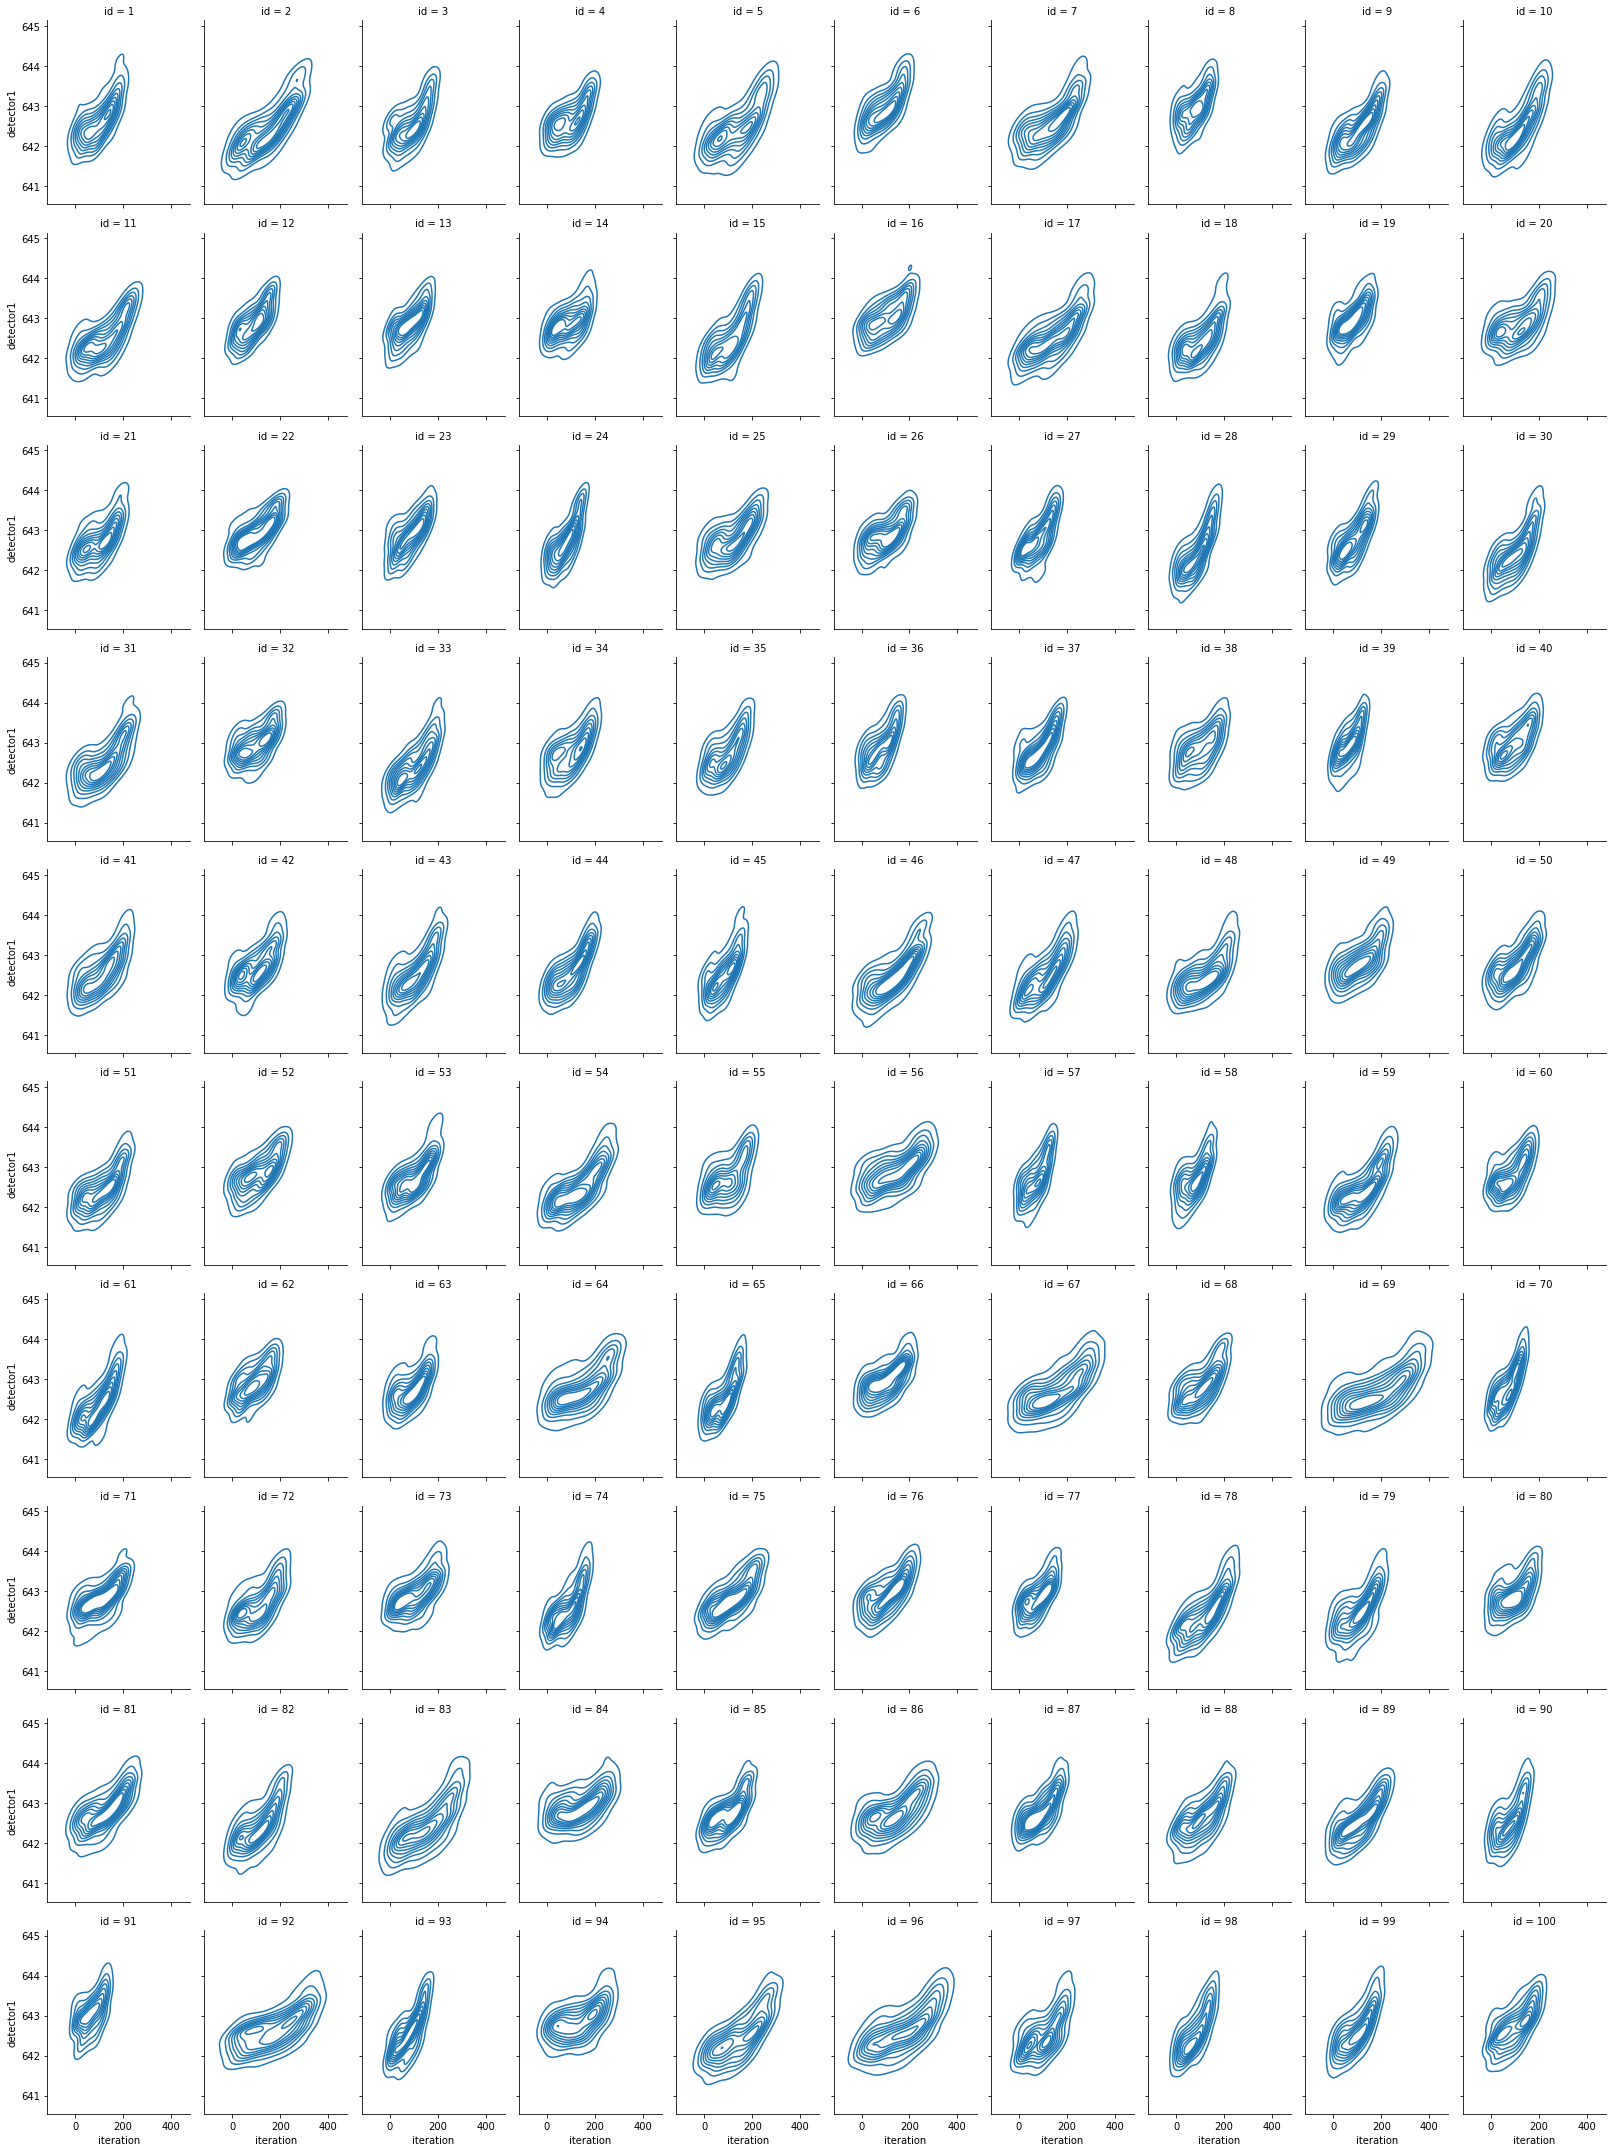

In [3]:
sns.displot(data=train_data, kind='kde',
            x="iteration", y="detector1",
            col="id", col_wrap=10,
            height=3, aspect=.75)

In [4]:
#Normalize the training set
cols_normalize = train_data.columns.difference(['id','iteration','Threshold'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_data[cols_normalize]), 
                             columns=cols_normalize, index=train_data.index)
join_df = train_data[train_data.columns.difference(cols_normalize)].join(norm_train_df)
train_data = join_df.reindex(columns=train_data.columns)

#Normalize the test set
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_data[cols_normalize]), 
                            columns=cols_normalize, index=test_data.index)
test_join_df = test_data[test_data.columns.difference(cols_normalize)].join(norm_test_df)
test_data = test_join_df.reindex(columns=test_data.columns)
test_data = test_data.reset_index(drop=True)

### Visualizing test data after normalization
Test data description. Covariance of different detectors from the same id during an iteration

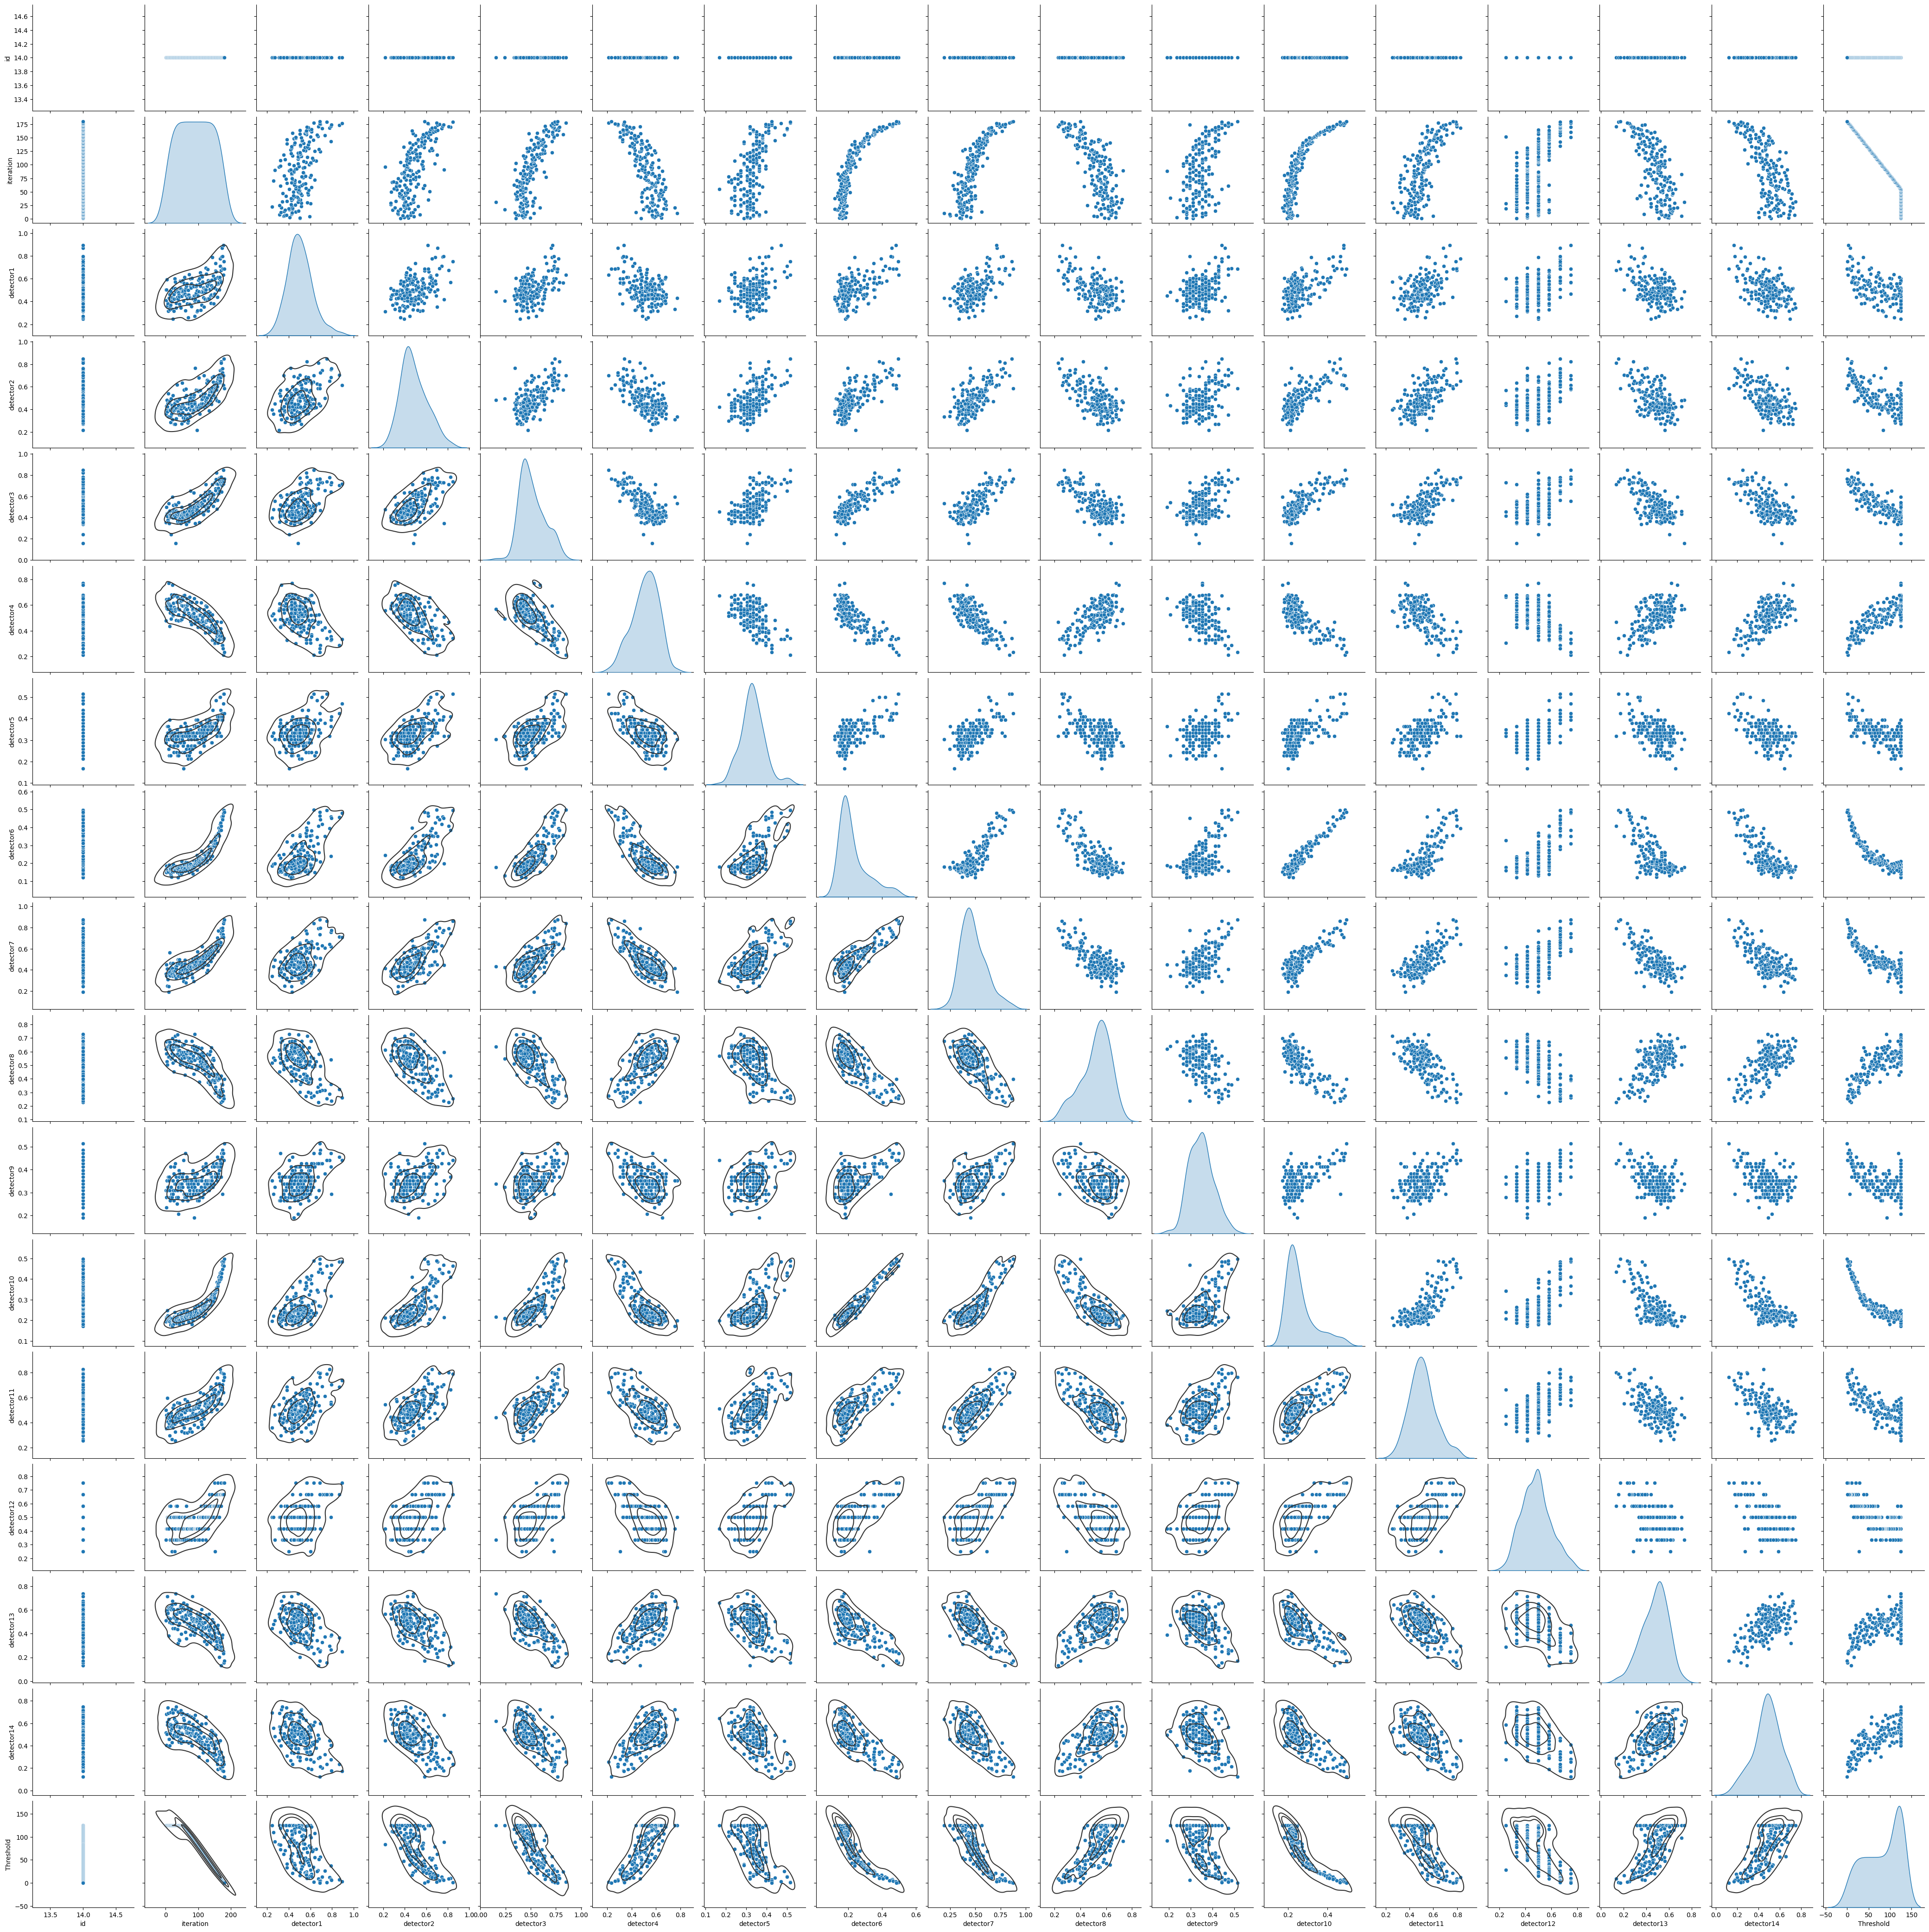

In [5]:
g = sns.pairplot(data=test_data,  diag_kind="kde", )
g.map_lower(sns.kdeplot, levels=4, color=".2", warn_singular=False)

In [6]:
# Sliding window size of 40 iterations
sequence_length = 40

# generate labels
label_gen = [gen_labels(train_data[train_data['id']==id_], sequence_length, ['Threshold']) 
             for id_ in train_data['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)

In [7]:
#  Select useful detectors only feature columns
sequence_cols = ['detector1','detector2','detector3','detector4','detector5','detector6',
                 'detector7','detector8','detector9','detector10','detector11',
                 'detector12','detector13','detector14']

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_data[train_data['id']==id_], 
                             sequence_length, sequence_cols)) 
           for id_ in train_data['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

In [8]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

# Create Model

In [9]:
# Clear artifacts and set random seed to ensure repeatability
keras.backend.clear_session()
np.random.seed(42)

#Create model
model_DCNN = DCNN(sequence_length, nb_features, nb_out)

#Creat model checkpoint to save the best model performance
model_checkpoint = keras.callbacks.ModelCheckpoint("models/predictive_maintenance_best_results.h5", save_best_only=True)

#specify ealy_callback to stop training model if there's no improvement after 10 epochs    
early_stopping = keras.callbacks.EarlyStopping(patience=30)

# Check the model architecture
model_DCNN.summary() 

40 14 1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 128)           14464     
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 256)           262400    
                                                                 
 conv1d_2 (Conv1D)           (None, 40, 256)           524544    
                                                                 
 conv1d_3 (Conv1D)           (None, 40, 128)           262272    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                

## Training step

In [10]:
# Train the model
history = model_DCNN.fit(seq_array, label_array, epochs=500, batch_size=200,
                         validation_split=0.2, callbacks=[early_stopping, 
                         model_checkpoint], verbose=0)

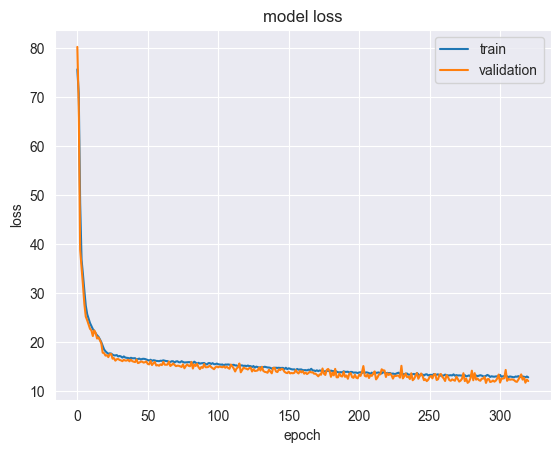

In [11]:
#Plot the losses  
sns.set_style("darkgrid")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

## Evaluation step

In [12]:
#load the best state of the model
model= load_model("models/predictive_maintenance_best_results.h5", custom_objects={'r2_keras': r2_keras,'rmse':rmse})

In [13]:
# generate test sequences and convert to numpy array
test_gen = (list(gen_sequence(test_data[test_data['id']==id_], sequence_length,
            sequence_cols)) for id_ in test_data['id'].unique())

# generate sequences and convert to numpy array
test_gen = np.concatenate(list(test_gen)).astype(np.float32)

# generate test labels
test_target = [gen_labels(test_data[test_data['id']==id_], sequence_length,
               ['Threshold']) for id_ in test_data['id'].unique()]
y_true = np.concatenate(test_target).astype(np.float32)

In [14]:
#predict on the test data
pred = model.predict(test_gen, verbose=0)

# Calculating rmse
final_mse = keras.metrics.mean_squared_error(y_true, pred)
final_rmse = np.round(np.mean(np.sqrt(final_mse)), 2)
print( "Mean RMSE is", "\033[1;32m", final_rmse, "\033[0;0m")

Mean RMSE is  7.57 


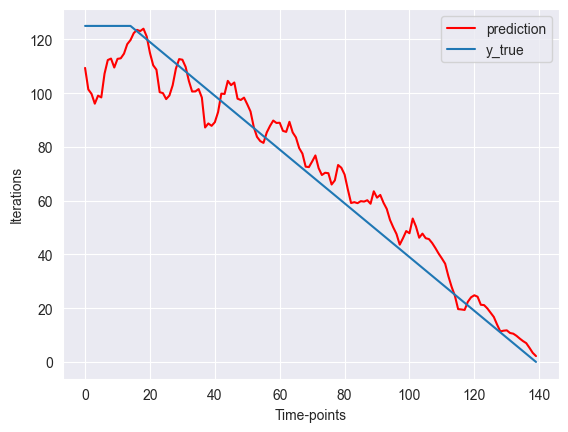

In [15]:
#Plot the predicted versus true RUL trend
time = np.arange(test_gen.shape[0])
sns.set_style("darkgrid")
plt.plot(time, pred, 'r')
plt.plot(time, y_true)
plt.legend(['prediction', 'y_true'])
plt.xlabel("Time-points")
plt.ylabel("Iterations")
plt.show()